# Notebook for "Synthetic observations from deep generative models and binary omics data with limited sample size"
In this notebook, we show how to employ the three generative approaches, that we studied in the non-conditional setting. Users can simulate binary data. These data can then be employed for training a variational autoencoder (VAE), deep Boltzmann machine (DBM and a generative adversarial network (GAN). Synthetic observations, generated by the approaches can be visually inspected. Finally the three approaches can be compared in terms of the learnt odds ratios as shown in the manuscript

First we install the necessary dependencies by loading a pre-configured environment. 

In [1]:
] activate .

 Activating environment at `~/Synthetic-observations-from-deep-generative-models-and-binary-omics-data-with-limited-sample-size/Project.toml`


In [2]:
] instantiate

## Definition of helper functions
Here we load necessary packages and define helper functions such as functions to compute the log odds ratios. Except for the below defined, standard, julia packages, the whole code is embedded in this notebook.

In [3]:
using Random 
using Distances
using Clustering
using PyPlot
using Flux # Version 0.9
using Statistics
import Distributions: logpdf, Bernoulli, Normal
using Dates
using BoltzmannMachines
using LinearAlgebra

"""Groups observations by k-means clustering for better visual inspection of simulated data, used for training and generated synthetic observations."""
function sort_for_plotting(x)
    kmeans_res = kmeans(Transpose(x),2).assignments
    return vcat(x[kmeans_res.==1,:],x[kmeans_res.==2,:])
end

"""Calculates odds ratios for a data matrix x where observations are arranged in rows."""
function oddsratio(x)
        N, dim = size(x)
        s = sum(x, dims=1)
        OR = zeros(dim,dim)
        for (i,j) in Iterators.product(1:dim,1:dim)
            if i != j
                a = N - sum(min.(x[:,i] .+ x[:,j], 1))      # ij_00
                diff = x[:,i] .- x[:,j]
                b = sum(1 .*( diff .== -1 ))                # ij_01
                c = sum(1 .*( diff .== 1 ))                 # ij_10
                d = sum(x[:,i] .* x[:,j])                   # ij_11
                OR[i,j] = (max(a,0.5)*max(d,0.5)/max(b,0.5)/max(c,0.5))
            end
        end
        return OR
end

"""Calculate the average odds ratios over in this example 200 data-sets sampled from trained generative models. The function does also output the variance of the odds ratios which we do not study in this example.""" 
function mean_and_variance(draw::Function; num_samples = 10)
    x1 = draw()
    data = zeros(size(x1,1), size(x1,2), num_samples)
    data[:,:,1] = x1
    for i in 2:num_samples
        data[:,:,i] = draw()
    end
    µ = (sum(data, dims=3)./num_samples)[:,:,1]
    σ² = zeros(size(x1))
    for i in 1:num_samples
        σ² += (data[:,:,i] .- µ).^2
    end
    σ² = σ²./(num_samples - 1)
    return σ², µ
end
"""Function helps to extract the odds ratios between a given set of variables."""
function block_index(i,j,k,l,p=p)
    I = Int[]
    for kdx in (k+1):l
        for idx in i:j
            if idx < kdx
                push!(I,idx + (kdx - 1)*p)
            end
        end
    end
    return I
end

# cross entropy (reconstruction error) loss function for VAE and GAN
logpdf(b::Bernoulli, y::Bool) = y * log(b.p + eps()) + (1 - y) * log(1 - b.p + eps())

logpdf (generic function with 66 methods)

## Simulation design
We first show how to simulate the binary simulated data as shown in Figure 1 of the manuscript. While the information-carrying variables are limited to ```10```, the number of noise variables can be controlled by altering ```p```. ```n``` indicates the number of simulated observations.

Here we define the function, needed to simulate the data. 

In [4]:
function generate_data(;n=100,p=50)
    x = 1.0*(rand(n,p) .> 0.9)
    z = fill(0.0,n,10)
    z[1:Int(n/2),1:5] .= 1
    z[(Int(n/2)+1):end,6:10] .= 1
    z = 1.0*(rand(n,10) .<= z*0.3)
    x[:,1:10] = 1.0*((x[:,1:10] .+ z) .> 0)
    x
end

generate_data (generic function with 1 method)

We  then simulate a small number of observations for grasping the structure ...

In [5]:
n = 100
p = 50
x = generate_data(n=n,p=p);

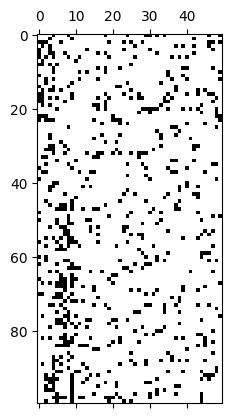

PyObject <matplotlib.image.AxesImage object at 0x7f2f276f9e80>

In [6]:
PyPlot.spy(collect(sort_for_plotting(x)))

... and then simulate a larger number (```5000```) of observations for obtaining reasonable training performance with all approaches.

In [7]:
Random.seed!(0)
n = 5000
p = 50
x = generate_data(n=n,p=p);

We then compute the log odds ratios from the data.

In [8]:
OR_data = log.(oddsratio(x));

... and visually inspect the log odds ratios.

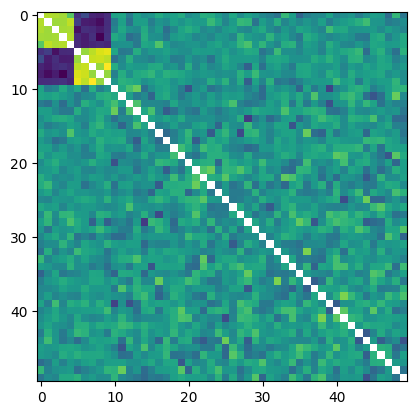

PyObject <matplotlib.image.AxesImage object at 0x7f2f45017eb0>

In [9]:
PyPlot.imshow(collect(OR_data))

## Training the deep generative approaches on the simulated data and evaluation of log odds ratios from generated synthetic observations

In this section, we demonstrate how to train the three discussed deep generative approaches on the simulated data, that were created in the previous section. During training we evaluate the log odds ratios of generated synthetic observations. We draw for ```evaliterations``` time  ```evalsamples``` observations and, as demonstrated in the manuscript, report the averages over the ```evaliterations```.
After training, we visually inspect the generated synthetic observations.

In [10]:
evalsamples = 100 # number of synthetic observations
evaliterations = 200 # number of times the synthetic observations are drawn

200

### VAE 

First, we define the architecture of the VAE. We define the number of hidden units in the encoder and decoder networks (```Dh```) and the set the dimensionality of the latent encodings we learn (```Dz```).

In [11]:
# Latent dimensionality, # hidden units.
Dz, Dh = 10, 30

(10, 30)

Then we set up the encoder network,

In [12]:
# Components of recognition model / "encoder" MLP.
A, latentμ, latentlogσ = Dense(p, Dh, tanh), Dense(Dh, Dz), Dense(Dh, Dz)
g(X) = (h = A(X); (latentμ(h), latentlogσ(h)))

g (generic function with 1 method)

and we set up the decoder network.

In [13]:
# Generative model / "decoder" MLP.
gen = Chain(Dense(Dz, Dh, tanh), Dense(Dh,p, σ))

Chain(Dense(10, 30, tanh), Dense(30, 50, σ))

We create a function to sample from the nodes which represent $\mu$ and $\sigma$ of the normally distributed posterior distribution.

In [14]:
latentz(μ, logσ) = μ + exp.(logσ) * randn() # draw a N(μ,σ^2) distributed RV

latentz (generic function with 1 method)

We set up the loss function.

In [15]:
# KL-divergence between approximation posterior and N(0, 1) prior.
kl_q_p(μ, logσ) = 0.5 * sum(exp.(2 .* logσ) + μ.^2 .- 1 .- (2 .* logσ))

# logp(x|z) - conditional probability of data given latents.
logp_x_z(x, z) = sum(logpdf.(Bernoulli.(gen(z)), x))

# Monte Carlo estimator of mean ELBO (Evidence Lower BOund) using M samples.
L̄(X) = ((μ̂, logσ̂) = g(X); (logp_x_z(X, latentz.(μ̂, logσ̂)) - kl_q_p(μ̂, logσ̂)) / batch_size)

VAE_loss(X) = -L̄(X) + 0.001 * sum(x->sum(x.^2), params(gen)) # add L2-Regularization to loss function

VAE_loss (generic function with 1 method)

We split the training data into batches according to ```batch_size```.

In [16]:
batch_size = 32
data = [x[i,:]' for i in Iterators.partition(1:n, batch_size)];

We then define a function to sample from the trained model.

In [17]:
function generate(num)
    x_gen = fill(0.0,num,p)
    for i = 1:num
        x_gen[i,:] = gen(latentz.(zeros(Dz), zeros(Dz))).data
    end
    return rand.(Bernoulli.(x_gen)) .* 1.0
    

end

generate (generic function with 1 method)

Finally we train for ```last_epoch``` epochs. During training, we investigate the average log odds ratios at 20 epochs (```VAE_epochs```) during training. We set the learning rate according to (```learning_rate```).

In [18]:
last_epoch=1000
VAE_means = Array{Array{Float64,2},1}();
VAE_epochs = collect( 1:max(1,Int64(floor(last_epoch/20))):(last_epoch) );
learning_rate = 0.00001
opt = ADAM(learning_rate)

ADAM(1.0e-5, (0.9, 0.999), IdDict{Any,Any}())

In [19]:
for epoch in 1:last_epoch
    Flux.train!(VAE_loss, params(A, latentµ, latentlogσ, gen), zip(data), opt)
    if epoch in VAE_epochs
        print(string("Epoch: ",epoch-1,"\n"))
        σ², µ = mean_and_variance(() -> log.(oddsratio(generate(evalsamples))), num_samples = evaliterations)
        push!(VAE_means, µ)
    end
end
print("Finished Training\n")

Epoch: 0
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Epoch: 300
Epoch: 350
Epoch: 400
Epoch: 450
Epoch: 500
Epoch: 550
Epoch: 600
Epoch: 650
Epoch: 700
Epoch: 750
Epoch: 800
Epoch: 850
Epoch: 900
Epoch: 950
Finished Training


#### Plotting a snippet of data 
We can take a look at the generated data after the last training epoch here. On the x-axis are the different features of the simulated data, while the y-axis shows the different samples. 

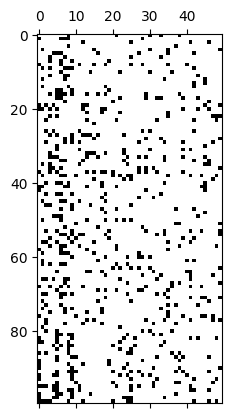

PyObject <matplotlib.image.AxesImage object at 0x7f2f2a72e880>

In [20]:
PyPlot.spy(collect(sort_for_plotting(generate(100))))

### DBM 
We now train a deep Boltzmann machine (DBM). Since we employ the julia package ```BoltzmannMachines```, we do not have to set up the generative model manually. We initiate the architecture of the DBM and then train it on the same artificially generated data for ```last_epoch``` epochs, as we did train the VAE on. The DBM has ```Dh2``` units in the second hidden layer ($h^{(2)}$) and ```Dh1``` units in the first hidden layer ($h^{(1)}$) 

In [21]:
#define parameters
last_epoch = 1000
learning_rate = 0.05
learning_rate_pretraining = 0.002
Dh2, Dh1 = 10, 30

DBM_means = Array{Array{Float64,2},1}();
DBM_epochs = collect( 1:max(1,Int64(floor(last_epoch/20))):(last_epoch) );

Since DBMs are trained in a two-step process, we first perform layer wise pre-training followed by joint refinement of weights. Both steps are implemented in the function ```fitdbm``` from the ```BoltzmannMachines``` package. In this code block we define the number of epochs for pre-training based on the number of observations available for training. From our experience 400.000 parameter updates during pre-training result in a decent performance.

In [22]:
epochs_pretrain = Int(400000/n)
println(string("Pretraining for ",epochs_pretrain," epochs."))

Pretraining for 80 epochs.


In [23]:
dbm = fitdbm(x;
    # pre-training
    learningratepretraining = learning_rate_pretraining,
    epochspretraining = epochs_pretrain,
    pretraining = [
        TrainLayer(nhidden = Dh1);
        TrainLayer(nhidden = Dh2)
    ],
    learningrate = learning_rate,
    epochs = last_epoch,
    monitoring = (dbm, epoch) ->
        begin
            if epoch in DBM_epochs
                println("Epoch: ", epoch-1)
                σ², µ = mean_and_variance(() -> log.(oddsratio(samples(dbm, evalsamples))), num_samples = evaliterations)
                push!(DBM_means, µ)
            end
        end
    );

print("Finished Training\n")

Epoch: 0
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Epoch: 300
Epoch: 350
Epoch: 400
Epoch: 450
Epoch: 500
Epoch: 550
Epoch: 600
Epoch: 650
Epoch: 700
Epoch: 750
Epoch: 800
Epoch: 850
Epoch: 900
Epoch: 950
Finished Training


#### Plotting a snippet of data
We can take a look at generated data from our trained DBM now:

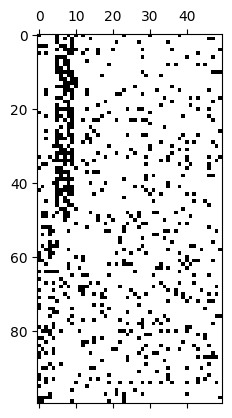

PyObject <matplotlib.image.AxesImage object at 0x7f2f44f4f1c0>

In [24]:
PyPlot.spy(collect(sort_for_plotting(samples(dbm,100))))

### GAN 
Now, we define the last of three models, the GAN. We set up  the architecture and train the model on the same data, that we trained the other two models on.

### Definition of functions needed to train the GAN

We need to define several functions to set up and train a GAN. These functions are rather independent on tunable parameters and are mainly needed to set up the structure of the GAN.

In [25]:
struct GAN
    g # generator
    gg # non-trainable generator copy
    d # discriminator
    dd # non-trainable discriminator copy
    pz # code distribution
end

function train(gan::GAN,batch_size::Int64)
    for I in random_batch_index(x, batch_size)
        m = length(I)
        # sample data and generate codes
        z = getcode(gan,m)

        # discriminator training
        Dl = Dloss(gan, x[I,:]',z)
        Flux.Tracker.back!(Dl)
		for param in params(gan.d)
			Flux.Tracker.update!(Dopt, param, Flux.Tracker.grad(param))
		end

        # generator training
        Gl = Gloss(gan, z)
        Flux.Tracker.back!(Gl)
        for param in params(gan.g)
			Flux.Tracker.update!(Gopt, param, Flux.Tracker.grad(param))
		end
    end
end

function random_batch_index(x::AbstractArray, batch_size=1; dims=1)
    n = size(x,dims)
    Iterators.partition(shuffle(1:n), batch_size)
end

Flux.@treelike GAN

freeze(m) = Flux.mapleaves(Flux.Tracker.data,m)

GAN(G::Flux.Chain, D::Flux.Chain; pz=randn) = GAN(G, freeze(G), D, freeze(D), pz)

getcode(gan::GAN) = Float64.(gan.pz(size(params(gan.g).order[1],2)))
getcode(gan::GAN, n::Int) = Float64.(gan.pz(size(params(gan.g).order[1],2), n))
generate(gan::GAN) = ((gan.g(getcode(gan)).data) .>= 0.5) .* 1.0
generate(gan::GAN, n::Int) = ((gan.g(getcode(gan, n)).data) .>= 0.5) .* 1.0

generate (generic function with 3 methods)

Here we set up the generator and discriminator loss.

In [26]:
Dloss(gan::GAN, X, Z) = - Float64(0.5)*(Statistics.mean(log.(gan.d(X) .+ eps(Float64))) + Statistics.mean(log.(1 .- gan.d(gan.gg(Z)) .+ eps(Float64))))
Gloss(gan::GAN, Z) = - Statistics.mean(log.(gan.dd(gan.g(Z)) .+ eps(Float64)))

Gloss (generic function with 1 method)

Finally we specify the architecture of the GAN. We have ```Dhg``` units in the hidden layer of the generator network and ```Dhd``` units in the hidden layer of the discriminator network. The latent space has ```Dz``` dimensions.

In [27]:
Dhg = 30
Dhd = 25
Dz = 10
generator = Chain(Dense(Dz, Dhg, NNlib.leakyrelu), Dense(Dhg, p, NNlib.σ))
discriminator = Chain(Dense(p, Dhd, NNlib.leakyrelu), Dense(Dhd, 1, NNlib.σ))

Chain(Dense(50, 25, leakyrelu), Dense(25, 1, σ))

Having set up the GAN, we train for ```last_epoch``` epochs. Using a learning rate of ```learning_rate``` and a batch size of ```batch_size```.

In [28]:
last_epoch = 10000
learning_rate = 0.00001
batch_size = 32
gan = GAN(generator, discriminator, pz=randn)

Dopt = ADAM(learning_rate) # params(gan.d)
Gopt = ADAM(learning_rate) # params(gan.g)

GAN_means = Array{Array{Float64,2},1}();
GAN_epochs = collect( 1:max(1,Int64(floor(last_epoch/20))):(last_epoch) );

In [29]:
for epoch in 1:last_epoch
	if epoch in GAN_epochs
		train(gan, batch_size)
        print(string("Epoch: ",epoch -1,"\n"))
		σ², µ = mean_and_variance(() -> log.(oddsratio(generate(gan, evalsamples)')), num_samples = evaliterations)
		push!(GAN_means, µ)
	end
end
print("Finished Training\n")

Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
Epoch: 3000
Epoch: 3500
Epoch: 4000
Epoch: 4500
Epoch: 5000
Epoch: 5500
Epoch: 6000
Epoch: 6500
Epoch: 7000
Epoch: 7500
Epoch: 8000
Epoch: 8500
Epoch: 9000
Epoch: 9500
Finished Training


#### Plotting a snippet of data
We can plot generated data from the trained GAN:

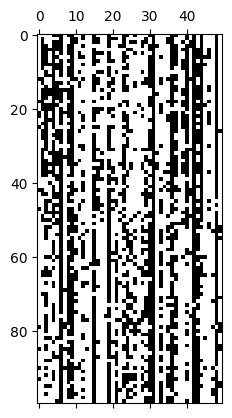

PyObject <matplotlib.image.AxesImage object at 0x7f2f44f1d640>

In [30]:
PyPlot.spy(collect(sort_for_plotting(Transpose(generate(gan,100)))))

## Comparing the three approaches in terms of their log odds ratios
After training all three approaches, we can compare them in terms of the learnt log odds ratios. 
The grafic displays the log odds-ratios on the y-axis for twenty equidistant steps during training. On the x-axis are the training epochs. 

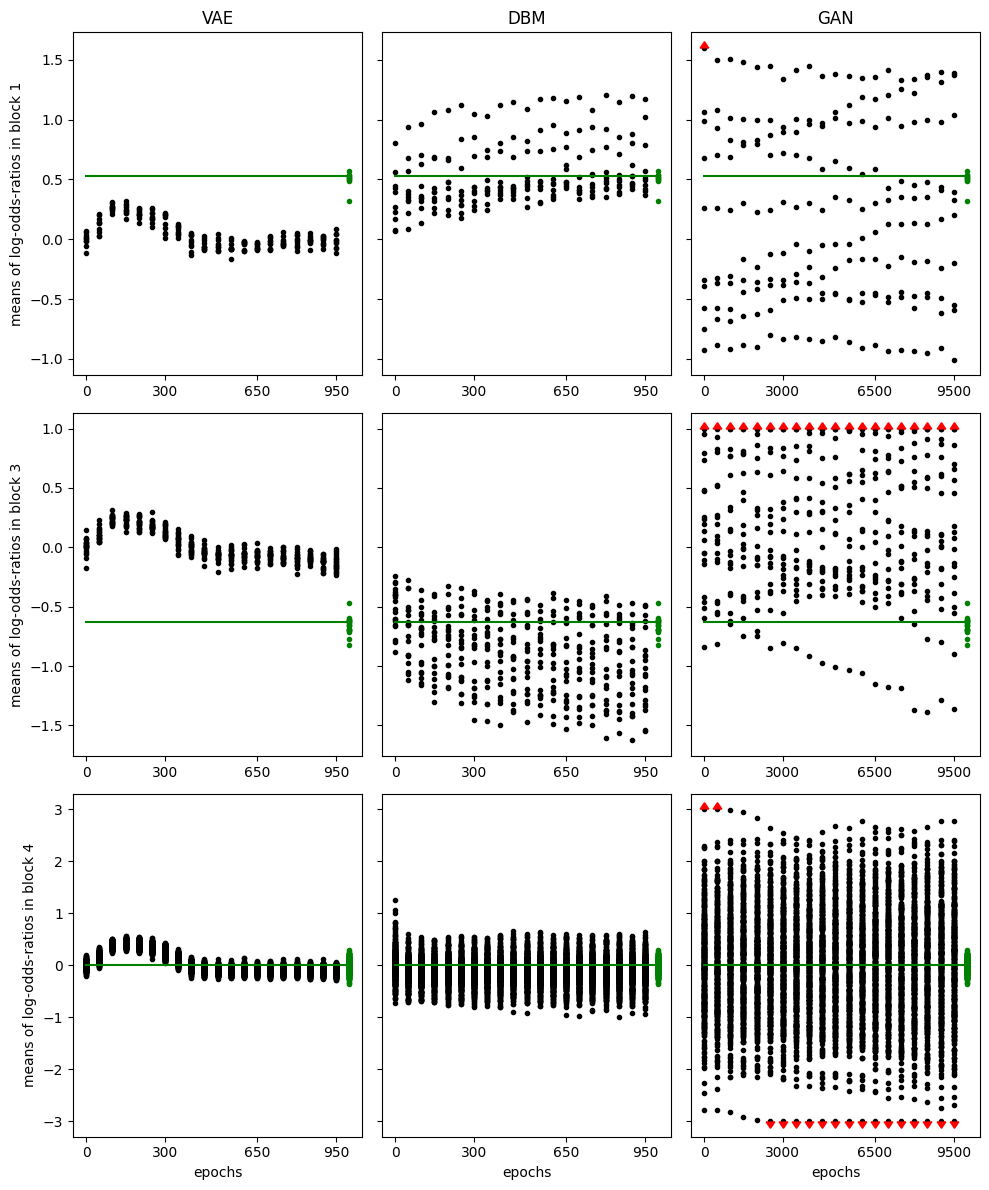

In [31]:
OR_SIGNAL = 1.698318604 #The "true" odds-ratios from our artificial SNP-data based on our sampling procedure
OR_NEGSIGNAL = 0.5351239669421487

bounds = [(-1.6, 1.6), (-2.5, 1.0), (-3.0, 3.0)]

f, axes = plt.subplots(3, 3, sharey="row" ,figsize=(10,12))

I = block_index(1,5,6,10)

for (model_index, model) in enumerate(["VAE", "DBM", "GAN"])

    #defining the areas of the different block to evaluate
    I = block_index(1,5,1,5); J = block_index(1,5,6,10); K = block_index(6,10,6,10); L = block_index(1,10,11,50); M = block_index(11,50,11,50);

    if model == "VAE"
        num_epochs = length(unique(VAE_epochs))
        epochs = VAE_epochs[1:num_epochs] .-1
        means = zeros(p, p, num_epochs)
        for i in 1:num_epochs
            means[:,:,i] = VAE_means[i]
        end
    elseif model == "DBM"
        num_epochs = length(unique(DBM_epochs))
        epochs = DBM_epochs[1:num_epochs] .-1
        means = zeros(p, p, num_epochs)
        for i in 1:num_epochs
            means[:,:,i] = DBM_means[i]
        end
    elseif model == "GAN"
        num_epochs = length(unique(GAN_epochs))
        epochs = GAN_epochs[1:num_epochs] .-1
        means = zeros(p, p, num_epochs)
        for i in 1:num_epochs
            means[:,:,i] = GAN_means[i]
        end
    end

	for (ax_index,(ax, block, truth, (lower_bound, upper_bound))) in enumerate(zip((axes[1, model_index], axes[2, model_index], axes[3, model_index]), [I,J,L], [log(OR_SIGNAL), log(OR_NEGSIGNAL), 0.0], bounds))
		for (index_epoch, epoch) in enumerate(epochs)
			ax.scatter(epoch*ones(length(block)), max.(min.(means[:,:,index_epoch][block],upper_bound),lower_bound), c="000", marker=".")
			if any(means[:,:,index_epoch][block] .> upper_bound)
				ax.scatter(epoch, upper_bound, marker=10, c="r")
			end
			if any(means[:,:,index_epoch][block] .< lower_bound)
				ax.scatter(epoch, lower_bound, marker=11, c="r")
			end
		end
		ax.scatter((epochs[end]+epochs[2]-1)*ones(length(block)), OR_data[block], marker=".", c="g")
        ax.plot(vcat(epochs,[(epochs[end]+epochs[2]-1)]), truth*ones(length(epochs)+1), c="g", label="truth")
		ax.set_xticks(epochs[[1,7,14,20]])
	end
end

axes[1, 1].set_title("VAE")
axes[1, 2].set_title("DBM")
axes[1, 3].set_title("GAN")
axes[1, 1].set_ylabel("means of log-odds-ratios in block 1")
axes[2, 1].set_ylabel("means of log-odds-ratios in block 3")
axes[3, 1].set_ylabel("means of log-odds-ratios in block 4")
axes[3, 1].set_xlabel("epochs")
axes[3, 2].set_xlabel("epochs")
axes[3, 3].set_xlabel("epochs")
plt.tight_layout(h_pad=1.0, rect=[0, 0, 1, 1])
plt.show()